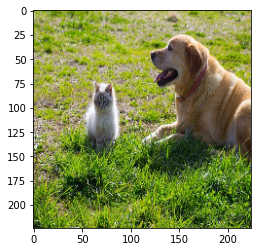

In [1]:
"""
Grad CAM을 사용하면 모델이 이미지의 어떤 부분을 중점적으로 관찰하고 있는지 확인할 수 있다
따라서 모델이 개라고 분류한다면 이미지의 특정한 위치에서 개의 특징을 잡아내고 있다는 가정을 할 수 있다
다음 VGG16 모델을 활용하여 앞의 사진을 분류 예측하고, 
이미지의 어떤 부분을 가장 중점적으로 포착하는지 확인한다

여기서 중요한 것은, 오차 역전파를 통해서 계산된 가중치 값들은 필터를 거쳐서 생성된 개별 이미지 텐서들이 
최종 분류 예측에 끼친 영향력을 나타내는 값이라고 생각할 수 있다.
따라서 각 특성맵 이미지의 가중치를 곱하고, 이 값들은 모두 더하면 원본 이미지에서
합성곱 필터들이 어떤 부분의 특징을 가장 주목하고 있는지 알 수 있다
"""
#필요한 패키지
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


#개와 고양이가 함계 있는 사진 표시
img = cv2.imread("aa.jpg")
img = cv2.resize(img,(224, 224))
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(imgRGB)

In [2]:
"""
VGG16 모델을 이미지넷 대회의 학습 가중치 그대로 불러 온다
여기서 주의할 점은 전이 학습과 달리 최종 분류층(top)까지 함께 포함해야한다
따라서 모델은 이미지넷 데이터로 학습한 그대로 샘플 이미지를 분류하게 된다

Grad CAM 모델은 VGG16 모델의 입력과 출력을 그대로 사용하고, 마지막 합성곱층(block5_conv3)의 출력을
Grad CAM 모델의 두번째 출력으로 추가하면 된다
Grad CAM 모델에 샘플 이미지를 입력하여 주면, 모델은 VGG16 모델의 이미지 분류 클래스를 예측하여 주고
동시에 합성곱층의 필터 연산 결과를 출력한다 
이 필터 연산 이미지를 분석하면 모델이 어느 부분을 관찰하는지 알게 된다
"""
# 기본적으로 cv2는 BGR로 불러오기 때문에 RGB로 변경
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 예측에 쓰일 기본 모델 VGG16을 사용할 예정
# block5_conv3 아웃풋과 VGG16 아웃풋을 동시에 가지는 모델을 정의
vgg_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top = True)
grad_cam_model = tf.keras.models.Model([vgg_model.input],
                                      [vgg_model.get_layer("block5_conv3").output, vgg_model.output])

#인풋 이미지를 넣어주고, block5_conv3 아웃풋과 결과값을 반환
conv_outputs, predictions = grad_cam_model.predict(np.reshape(rgb_img,(1, 224, 224, 3)))

# 가장 예측 확률이 높은 인덱스를 저장하고, class 값을 확인
img_index = np.argmax(predictions)
tf.keras.applications.vgg16.decode_predictions(predictions)

[[('n02099712', 'Labrador_retriever', 0.49398267),
  ('n02092339', 'Weimaraner', 0.24856639),
  ('n02099601', 'golden_retriever', 0.06568314),
  ('n02134084', 'ice_bear', 0.058719568),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.046956036)]]

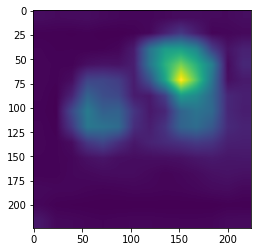

In [3]:
"""
이제 모델의 예측 확률이 가장 높은 클래스에 해당하는 인덱스(이미지넷은 1000개의 클래스를 가지고 있다)에 대한 
필터 이미지들의 가중치를 구한다
ReLU 함수를 거쳐서 음의 가중치를 제거하고 양의 가중치만을 남긴다
이들 가중치의 합을 필터 이미지에 곱한다
모든 필터 이미지에 대한 연산 결과를 더해서 하나의 가중치 이미지를 만든다

이 이미지를 원본 이미지 크기로 변환해 주고 0~1 범위의 값을 갖도록 조정한다 
이미지를 출력하면 Grad CAM 이 활성화된 영역을 확인할 수 있다
"""

# 가장 예측이 높은 인덱스에 대한 block5_conv3의 Gradient를 구한다.
with tf.GradientTape() as tape:
    conv_outputs,  predictions = grad_cam_model(np.reshape(rgb_img, (1, 224, 224, 3)))
    loss = predictions[:, img_index]
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# 음수는 그 결과를 반대하는 결과이므로,  생략한다.
# 즉 Relu를 통해 양의 Gradient만 취해준다.
grads = tf.keras.activations.relu(grads)

# grad를 채널별로 합해준다.
# 이값이 그 채널의 웨이트값이 된다.
grad_weights = tf.reduce_mean(grads, axis=(0,  1))

# block5_conv3의 아웃풋에 Grad채널의 웨이트값을 곱해준다.
cam = np.ones(output.shape[0: 2], dtype = np.float32)
for i,  w in enumerate(grad_weights):
    cam += w * output[:,  :,  i]

# 크기를 변경해 주고,  0~1 사이의 값을 가지도록 조정해 준다.
cam = cv2.resize(cam.numpy(), (224,  224))
grad_cam = (cam - cam.min()) / (cam.max() - cam.min())

# grad cam이 활성화된 영역을 표시해 본다.
plt.imshow(grad_cam)

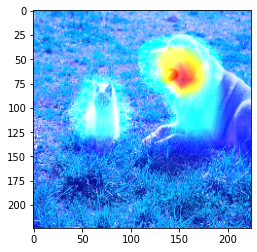

In [4]:
"""
앞서 구한 Grad CAM 가중치 이미지를 원본 이미지와 겹쳐서 출력한다 
다음 실행 결과를 보면 리트리버의 귀 부분을 주목하고 있는 것을 알 수 있다
즉 VGG16 이미지 분류 모델은 리트리버의 귀 부분의 특징을 
가장 중요하게 생각하고 최종 분류 예측을 한다고 말 할 수 있다.
"""
cam = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
cam = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
plt.imshow(cv2.add(cam, img))

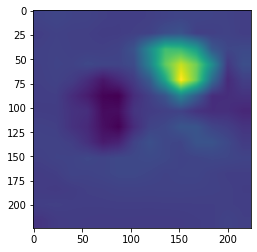

In [5]:
"""
이번에는 ReLU 함수를 적용하지 않고 음의 가중치를 양의 가중치와 함께 모두 통과시킨다
이들 가중치의 합을 필터 이미지에 곱하고 합하는 과정을 똑같이 진행해 Gradient 이미지를 만든다

"""

# 가장 예측이 높은 인덱스에 대한 block5_conv3의 Gradient를 구한다.
with tf.GradientTape() as tape:
    conv_outputs,  predictions = grad_cam_model(np.reshape(rgb_img, (1, 224, 224, 3)))
    loss = predictions[:, img_index]
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# 음수는 그 결과를 반대하는 결과이므로,  생략한다.
# 즉 Relu를 통해 양의 Gradient만 취해준다.
#grads = tf.keras.activations.relu(grads)

# grad를 채널별로 합해준다.
# 이값이 그 채널의 웨이트값이 된다.
grad_weights = tf.reduce_mean(grads, axis=(0,  1))

# block5_conv3의 아웃풋에 Grad채널의 웨이트값을 곱해준다.
cam = np.ones(output.shape[0: 2], dtype = np.float32)
for i,  w in enumerate(grad_weights):
    cam += w * output[:,  :,  i]

# 크기를 변경해 주고,  0~1 사이의 값을 가지도록 조정해 준다.
cam = cv2.resize(cam.numpy(), (224,  224))
grad_cam = (cam - cam.min()) / (cam.max() - cam.min())

# grad cam이 활성화된 영역을 표시해 본다.
plt.imshow(grad_cam)

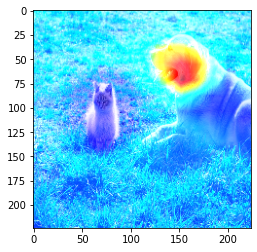

In [6]:
"""
원본 이미지에 겹쳐서 출력하면 고양이 형태에 대해서 음의 가중치를 인식하고 있는 것을 확인 할 수 있다 
하지만 모델은 리트리버의 귀 부분에 강한 양의 가중치를 가지고 있기 때문에, 
특성 정보를 가지고 최종적으로 리트리버로 분류 한다
"""
cam = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
cam = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
plt.imshow(cv2.add(cam, img))